# Import das bibliotecas

In [195]:
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC
from sklearn import datasets, neural_network, metrics
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np

# Carrega o dataset de imagens

O dataset escolhido é um conjunto de imagens no formato JPEG de pessoas retiradas da internet. O dataset contem mais de 13.000 imagens, sendo que 1.680 possui mais de 1 foto presente no dataset. Cada imgem esta centrada em uma unica face e é composta pela descrição dos pixels como numeros float RGB entre 0 e 1.0. No dataset também esta presente uma lista com o nome de cada pessoa.

A primeira chamada do dataset é feita pegando apanas pessoas com mais de 70 fotos, ou seja, com bastante conteudo para treino e também garantindo o maximo de pixels possível.

In [196]:
people = fetch_lfw_people(min_faces_per_person=70, resize=1)

In [197]:
n_samples, height, width = people.images.shape

In [198]:
X = people.data
n_features = X.shape[1]

y = people.target
target_names = people.target_names
n_classes = target_names.shape[0]

In [199]:
print ("Numero de imagens:",n_samples,"\nPixels por imagem:",height*width)

Numero de imagens: 1288 
Pixels por imagem: 11750


# Pré processamento

Divide-se a quantidade de imagens para treinamento e para teste utilizando uma funçaõ de divisão randomica.

O atributo "test_size" da função define a porcentagem de imagens para teste.

Utiliza-se o algoritmo RandomizedPCA que faz uma redução linear dos dados, mantendo apenas os mais significativos. 

A variável "n_components" define a quantidade de elementos mantidos.

In [200]:
def pre_proc(n_componets,test_size,X, y,n_components,height,width):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    pca = RandomizedPCA(n_components=n_components,whiten=True).fit(X_train)
    eigenfaces = pca.components_.reshape((n_components, height, width))
    X_train_pca = pca.transform(X_train)
pre_proc(150,0.25,X, y,n_components,height,width)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


Podemos plotar algumas imagens, utilizando apenas os pixels que o PCA considerou relevantes para o algoritmo.

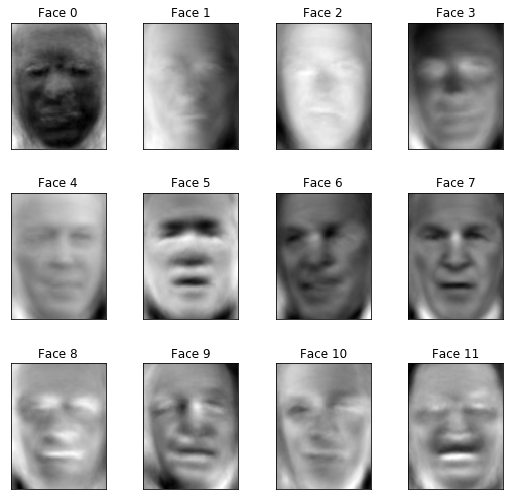

In [201]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99,
                        top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
 
eigenface_titles= []
for i in range(people.images.shape[0]):
    eigenface_titles.append("Face "+str(i))
 
plot_gallery(eigenfaces, eigenface_titles, h, w)
 
plt.show()

# SVC

## Treino 

Agora que temos nossos dados, podemos realizar o treino do algoritmo, assim como a predição. Primeira tentativa foi usando o GridSearchCV que realiza uma busca exaustiva, este por sua vez usa o SVC como estimador. 

In [202]:
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5], 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf'), param_grid)
clf = clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)

## Avaliação

Utilizando o "classification_report" temos informações sobre os dados obtidos a partir dos dados considerados verdadeiros e os preditos. Abaixo temos dados de precisão para as fotos de cada pessoa em específico e também a média geral.

In [204]:
print(classification_report(y_test, y_pred, target_names=target_names))
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:     %s'%(pred_name, true_name)
 
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
 
plot_gallery(X_test, prediction_titles, h, w, 6, 4)
plt.show()

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.67      0.80        21
     Colin Powell       0.86      0.86      0.86        72
  Donald Rumsfeld       0.90      0.70      0.79        27
    George W Bush       0.78      0.98      0.87       125
Gerhard Schroeder       0.96      0.79      0.86        28
      Hugo Chavez       1.00      0.64      0.78        11
       Tony Blair       0.97      0.74      0.84        38

      avg / total       0.87      0.85      0.85       322



## Validação cruzada

In [210]:
scores = cross_val_score(clf,X_train_pca,y_train)
np.mean(scores)

0.77344041548449771

# MLPC

## 10 neuronios

In [233]:
MLPC = neural_network.MLPClassifier(hidden_layer_sizes=(10, ),
activation='relu', # {identity, logistic, tanh, relu},
solver='adam', # {lbfgs, sgd, adam},
alpha=0.0001,
learning_rate='constant', # {constant, invscaling, adaptive},
learning_rate_init=0.001,
power_t=0.5,
max_iter=1000,
shuffle=True,
tol=0.00001,
verbose=True,
momentum=0.9,
validation_fraction=0.1)

In [234]:
MLPC.fit(X_train_pca,y_train)
y_pred = MLPC.predict(X_test_pca)

Iteration 1, loss = 2.29265984
Iteration 2, loss = 2.22359532
Iteration 3, loss = 2.16180715
Iteration 4, loss = 2.10322228
Iteration 5, loss = 2.04713474
Iteration 6, loss = 1.99362120
Iteration 7, loss = 1.94317394
Iteration 8, loss = 1.89375186
Iteration 9, loss = 1.84786518
Iteration 10, loss = 1.80266859
Iteration 11, loss = 1.76001279
Iteration 12, loss = 1.71946114
Iteration 13, loss = 1.67973614
Iteration 14, loss = 1.64223452
Iteration 15, loss = 1.60648510
Iteration 16, loss = 1.57097344
Iteration 17, loss = 1.53734695
Iteration 18, loss = 1.50455919
Iteration 19, loss = 1.47330986
Iteration 20, loss = 1.44223337
Iteration 21, loss = 1.41219657
Iteration 22, loss = 1.38396638
Iteration 23, loss = 1.35620642
Iteration 24, loss = 1.32970674
Iteration 25, loss = 1.30367719
Iteration 26, loss = 1.27846529
Iteration 27, loss = 1.25456082
Iteration 28, loss = 1.23087065
Iteration 29, loss = 1.20807740
Iteration 30, loss = 1.18535499
Iteration 31, loss = 1.16330662
Iteration 32, los

Iteration 271, loss = 0.06696354
Iteration 272, loss = 0.06653299
Iteration 273, loss = 0.06615231
Iteration 274, loss = 0.06574293
Iteration 275, loss = 0.06534503
Iteration 276, loss = 0.06494048
Iteration 277, loss = 0.06456574
Iteration 278, loss = 0.06418961
Iteration 279, loss = 0.06377432
Iteration 280, loss = 0.06340530
Iteration 281, loss = 0.06305663
Iteration 282, loss = 0.06270733
Iteration 283, loss = 0.06234227
Iteration 284, loss = 0.06199228
Iteration 285, loss = 0.06165018
Iteration 286, loss = 0.06132767
Iteration 287, loss = 0.06095159
Iteration 288, loss = 0.06060934
Iteration 289, loss = 0.06026997
Iteration 290, loss = 0.05994694
Iteration 291, loss = 0.05960265
Iteration 292, loss = 0.05926754
Iteration 293, loss = 0.05895083
Iteration 294, loss = 0.05862028
Iteration 295, loss = 0.05829011
Iteration 296, loss = 0.05797077
Iteration 297, loss = 0.05767185
Iteration 298, loss = 0.05734929
Iteration 299, loss = 0.05702810
Iteration 300, loss = 0.05674361
Iteration 

Iteration 541, loss = 0.01771935
Iteration 542, loss = 0.01766252
Iteration 543, loss = 0.01760247
Iteration 544, loss = 0.01754039
Iteration 545, loss = 0.01748217
Iteration 546, loss = 0.01741148
Iteration 547, loss = 0.01729131
Iteration 548, loss = 0.01716768
Iteration 549, loss = 0.01706663
Iteration 550, loss = 0.01697132
Iteration 551, loss = 0.01687507
Iteration 552, loss = 0.01678628
Iteration 553, loss = 0.01671331
Iteration 554, loss = 0.01664011
Iteration 555, loss = 0.01657384
Iteration 556, loss = 0.01650764
Iteration 557, loss = 0.01644178
Iteration 558, loss = 0.01638045
Iteration 559, loss = 0.01631639
Iteration 560, loss = 0.01625972
Iteration 561, loss = 0.01619517
Iteration 562, loss = 0.01613794
Iteration 563, loss = 0.01607848
Iteration 564, loss = 0.01601949
Iteration 565, loss = 0.01596372
Iteration 566, loss = 0.01590498
Iteration 567, loss = 0.01584786
Iteration 568, loss = 0.01579027
Iteration 569, loss = 0.01573607
Iteration 570, loss = 0.01568224
Iteration 

Iteration 846, loss = 0.00442339
Iteration 847, loss = 0.00441106
Iteration 848, loss = 0.00439641
Iteration 849, loss = 0.00438350
Iteration 850, loss = 0.00437147
Iteration 851, loss = 0.00435793
Iteration 852, loss = 0.00434386
Iteration 853, loss = 0.00433300
Iteration 854, loss = 0.00431880
Iteration 855, loss = 0.00430726
Iteration 856, loss = 0.00429316
Iteration 857, loss = 0.00428227
Iteration 858, loss = 0.00426909
Iteration 859, loss = 0.00425770
Iteration 860, loss = 0.00424484
Iteration 861, loss = 0.00423214
Iteration 862, loss = 0.00422004
Iteration 863, loss = 0.00420931
Iteration 864, loss = 0.00419544
Iteration 865, loss = 0.00418335
Iteration 866, loss = 0.00417122
Iteration 867, loss = 0.00415953
Iteration 868, loss = 0.00414735
Iteration 869, loss = 0.00413464
Iteration 870, loss = 0.00412353
Iteration 871, loss = 0.00411188
Iteration 872, loss = 0.00409991
Iteration 873, loss = 0.00408923
Iteration 874, loss = 0.00407749
Iteration 875, loss = 0.00406650
Iteration 

                   precision    recall  f1-score   support

     Ariel Sharon       0.89      0.76      0.82        21
     Colin Powell       0.87      0.86      0.87        72
  Donald Rumsfeld       0.81      0.78      0.79        27
    George W Bush       0.84      0.93      0.88       125
Gerhard Schroeder       0.88      0.75      0.81        28
      Hugo Chavez       0.62      0.73      0.67        11
       Tony Blair       0.94      0.79      0.86        38

      avg / total       0.86      0.85      0.85       322



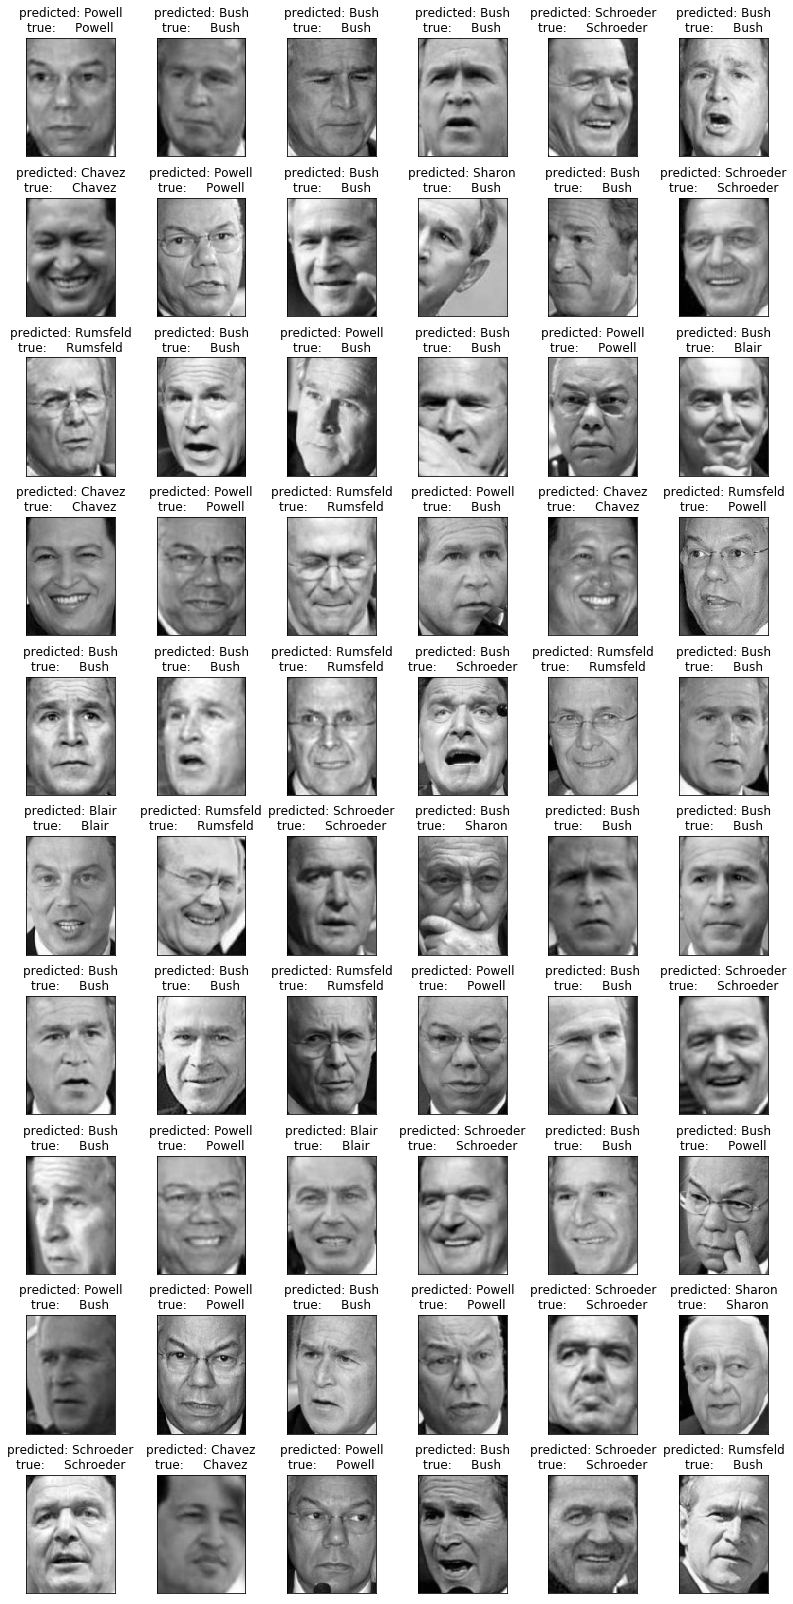

In [245]:
print(classification_report(y_test, y_pred, target_names=target_names))

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:     %s'%(pred_name, true_name)
 
    
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
 
plot_gallery(X_test, prediction_titles, height, width ,10, 6)
plt.show()


## 10000 neuronios

Iteration 1, loss = 1.50426695
Iteration 2, loss = 0.44243780
Iteration 3, loss = 0.16238412
Iteration 4, loss = 0.06614525
Iteration 5, loss = 0.03102480
Iteration 6, loss = 0.01645047
Iteration 7, loss = 0.01044101
Iteration 8, loss = 0.00747715
Iteration 9, loss = 0.00579784
Iteration 10, loss = 0.00466572
Iteration 11, loss = 0.00399147
Iteration 12, loss = 0.00350883
Iteration 13, loss = 0.00316783
Iteration 14, loss = 0.00289889
Iteration 15, loss = 0.00269648
Iteration 16, loss = 0.00251568
Iteration 17, loss = 0.00236744
Iteration 18, loss = 0.00223670
Iteration 19, loss = 0.00212146
Iteration 20, loss = 0.00201606
Iteration 21, loss = 0.00192034
Iteration 22, loss = 0.00183349
Iteration 23, loss = 0.00175429
Iteration 24, loss = 0.00167741
Iteration 25, loss = 0.00160913
Iteration 26, loss = 0.00154637
Iteration 27, loss = 0.00148520
Iteration 28, loss = 0.00142836
Iteration 29, loss = 0.00137736
Iteration 30, loss = 0.00132657
Iteration 31, loss = 0.00128059
Iteration 32, los

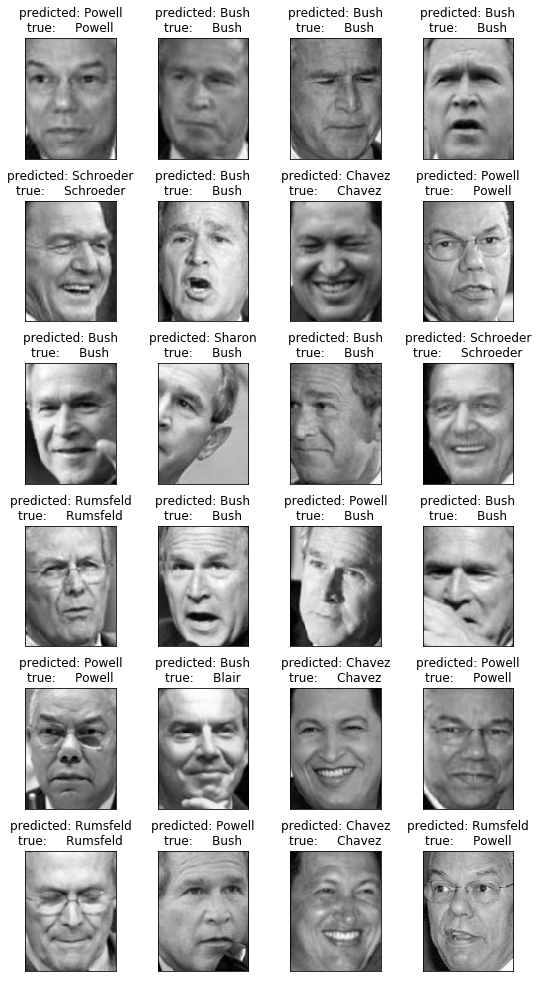

In [231]:
MLPC = neural_network.MLPClassifier(hidden_layer_sizes=(10000, ),
activation='relu', # {identity, logistic, tanh, relu},
solver='adam', # {lbfgs, sgd, adam},
alpha=0.0001,
learning_rate='constant', # {constant, invscaling, adaptive},
learning_rate_init=0.001,
power_t=0.5,
max_iter=1000,
shuffle=True,
tol=0.00001,
verbose=True,
momentum=0.9,
validation_fraction=0.1)


MLPC.fit(X_train_pca,y_train)
y_pred = MLPC.predict(X_test_pca)


print(classification_report(y_test, y_pred, target_names=target_names))
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:     %s'%(pred_name, true_name)
 
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
 
plot_gallery(X_test, prediction_titles, height, width ,10, 6)
plt.show()

## 10000 neuronios e tolerancia aumentada 100x

Iteration 1, loss = 1.49262876
Iteration 2, loss = 0.44029492
Iteration 3, loss = 0.15546898
Iteration 4, loss = 0.06321467
Iteration 5, loss = 0.02877178
Iteration 6, loss = 0.01590263
Iteration 7, loss = 0.01010947
Iteration 8, loss = 0.00714829
Iteration 9, loss = 0.00551204
Iteration 10, loss = 0.00451138
Iteration 11, loss = 0.00384504
Iteration 12, loss = 0.00340240
Iteration 13, loss = 0.00308024
Iteration 14, loss = 0.00283311
Iteration 15, loss = 0.00262732
Iteration 16, loss = 0.00245948


/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


                   precision    recall  f1-score   support

     Ariel Sharon       0.89      0.76      0.82        21
     Colin Powell       0.87      0.86      0.87        72
  Donald Rumsfeld       0.81      0.78      0.79        27
    George W Bush       0.84      0.93      0.88       125
Gerhard Schroeder       0.88      0.75      0.81        28
      Hugo Chavez       0.62      0.73      0.67        11
       Tony Blair       0.94      0.79      0.86        38

      avg / total       0.86      0.85      0.85       322



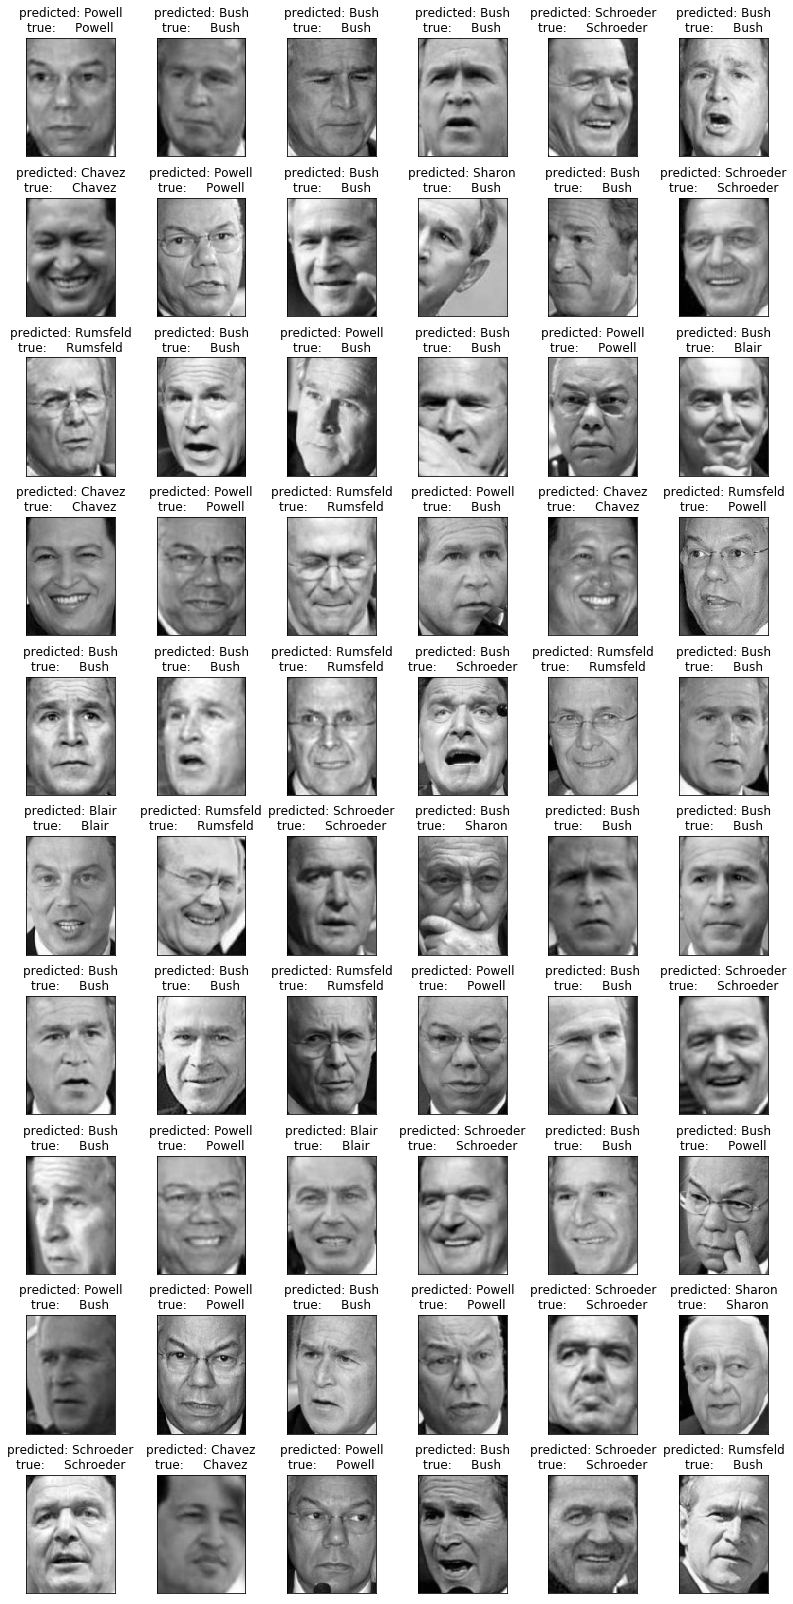

In [242]:
MLPC = neural_network.MLPClassifier(hidden_layer_sizes=(10000, ),
activation='relu', # {identity, logistic, tanh, relu},
solver='adam', # {lbfgs, sgd, adam},
alpha=0.0001,
learning_rate='constant', # {constant, invscaling, adaptive},
learning_rate_init=0.001,
power_t=0.5,
max_iter=1000,
shuffle=True,
tol=0.0000001,
verbose=True,
momentum=0.9,
validation_fraction=0.1)


MLPC.fit(X_train_pca,y_train)
y_pred = MLPC.predict(X_test_pca)


print(classification_report(y_test, y_pred, target_names=target_names))
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:     %s'%(pred_name, true_name)
 
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
 
plot_gallery(X_test, prediction_titles, height, width ,10, 6)
plt.show()

## Sem pre-processamento

In [ ]:
MLPC = neural_network.MLPClassifier(hidden_layer_sizes=(10000, ),
activation='relu', # {identity, logistic, tanh, relu},
solver='adam', # {lbfgs, sgd, adam},
alpha=0.0001,
learning_rate='constant', # {constant, invscaling, adaptive},
learning_rate_init=0.001,
power_t=0.5,
max_iter=1000,
shuffle=True,
tol=0.00001,
verbose=True,
momentum=0.9,
validation_fraction=0.1)


MLPC.fit(X_train,y_train)
y_pred = MLPC.predict(X_test)


print(classification_report(y_test, y_pred, target_names=target_names))
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:     %s'%(pred_name, true_name)
 
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
 
plot_gallery(X_test, prediction_titles, height, width ,10, 6)
plt.show()

Iteration 1, loss = 18.12397569
Iteration 2, loss = 17.06974542
Iteration 3, loss = 16.79696648
Iteration 4, loss = 17.59210039
Iteration 5, loss = 16.97459555
